In [1]:
import pyspark
import feedparser
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext 
from datetime import datetime, timedelta
from pyspark.sql.functions import desc, concat, lit
import findspark
findspark.init()
findspark.find()

# Create Spark Seesion
appName = "project"
master = "local"
jdbc_driver_path = "/opt/homebrew/Cellar/apache-spark/spark-3.5.2-bin-hadoop3/jars/postgresql-42.7.4.jar"
# Create Configuration object for Spark. 
# Here I use ChatGPT to help me debug the conection error from spark to jdbc, it helps me add additional SET configs.
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').set("spark.jars", jdbc_driver_path).set("spark.executor.extraClassPath", jdbc_driver_path).setAppName(appName).setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)
# You need to create SQL Context to conduct some database operations like what we wil
sqlContext = SQLContext(sc)
# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY") # CHAT-GPT gave me this line when I kept running into errors regarding spark version
spark.sparkContext.setLogLevel("ERROR")


C:\Users\micah\anaconda3\envs\sys_tools\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
import os
import csv
import requests

# dataset_folder_path = "C://Users//micah//OneDrive//Gmail OneDrive//Desktop//Jupyter Notebook Files//Sys_Toolchains//Sys_Tools_Project//"
dataset_folder_path  = "data_folder//"

dataset_names = os.listdir(dataset_folder_path)
dataset_names.remove("Career Mode female player datasets - FIFA 16-22.xlsx")
dataset_names.remove("Career Mode player datasets - FIFA 15-22.xlsx")
complete_file_paths = []

for file in dataset_names:
    complete_file_paths.append(dataset_folder_path + file)

In [3]:
male_players = complete_file_paths[len(complete_file_paths) // 2:]
print(male_players)
female_players = complete_file_paths[0: len(complete_file_paths) // 2]
print(female_players)

file0 = female_players[0] 
with open(f'{file0}', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    first_element = next(reader)
    column_names = []
    for row in first_element:
        column_names.append(row)

last_col_names = []

for path in complete_file_paths:
    with open(f'{path}', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        first_element = next(reader)
        column_names = []
        for row in first_element:
            column_names.append(row)
        if(column_names == last_col_names or path == file0): # This is how I know that the row names are thes smae for all the columns.
            print("Column names are the same")
        else:
            print("FALSE")
            print(path)
        last_col_names = column_names

['data_folder//players_15.csv', 'data_folder//players_16.csv', 'data_folder//players_17.csv', 'data_folder//players_18.csv', 'data_folder//players_19.csv', 'data_folder//players_20.csv', 'data_folder//players_21.csv', 'data_folder//players_22.csv']
['data_folder//female_players_16.csv', 'data_folder//female_players_17.csv', 'data_folder//female_players_18.csv', 'data_folder//female_players_19.csv', 'data_folder//female_players_20.csv', 'data_folder//female_players_21.csv', 'data_folder//female_players_22.csv']
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same
Column names are the same


In [4]:
from pyspark.sql.functions import lit

file0 = male_players[0] # need to read in male columns first because their data tables are more complete (and spark can infer the schema better)
file_name = file0.split("//")[-1] 
numbers_w_f_type = file_name.split("_")[-1]
cur_num = (file_name.split("_")[1]).split(".")[0]
cur_year = "20" + cur_num
cur_year = int(cur_year)
spark_df_all = spark.read.csv(file0, header=True, inferSchema=True)
spark_df_all = spark_df_all.withColumn("year", lit(cur_year))
spark_df_all = spark_df_all.withColumn("gender", lit("male"))


for file in male_players[1:]:
        cur_num = (file.split("//")[-1]).split("_")[1].split(".")[0]
        cur_year = "20" + cur_num
        cur_year = int(cur_year)
        print(cur_year)
        cur_spark_df = spark.read.csv(f"{file}", header=True, inferSchema=True)
        cur_spark_df = cur_spark_df.withColumn("year", lit(cur_year))
        cur_spark_df = cur_spark_df.withColumn("gender", lit("male"))
        spark_df_all = spark_df_all.union(cur_spark_df)

for file in female_players:
    file_name = file.split("//")[-1]
    if(file_name.split("_")[0] == "female"):
        numbers_w_f_type = file_name.split("_")[-1]
        cur_num = numbers_w_f_type.split(".")[0]
        cur_year = "20" + cur_num
        cur_year = int(cur_year)
        cur_spark_df = spark.read.csv(f"{file}", header=True, inferSchema=True)
        cur_spark_df = cur_spark_df.withColumn("year", lit(cur_year))
        cur_spark_df = cur_spark_df.withColumn("gender", lit("female"))
        spark_df_all = spark_df_all.union(cur_spark_df)
        
df_total = spark_df_all

2016
2017
2018
2019
2020
2021
2022


In [5]:
df_total = df_total.withColumn("id", concat(df_total["sofifa_id"], lit("_"), df_total["year"]))
column_order = ["id"] + [col for col in df_total.columns if col != "id"]
df_total = df_total.select(column_order)
# df_total.show(vertical=True)

In [6]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="brachiosaurus"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['table']="fifa.playerdata"


db_properties['driver']="org.postgresql.Driver"

df_total.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

### Injesting the Data from Postgresq

In [7]:
df_total = spark.read.format("jdbc")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.load()

df_total = df_total.filter(df_total["gender"] == "male")

### Question 1

In [8]:
from pyspark.sql import functions as F
from pyspark.sql.functions import desc, concat, lit, avg, asc, round


def club_contracts_players(df_total, X, Z, Y):
    filtered_df = df_total.filter(df_total["year"] == X)
    filtered_df = filtered_df.filter(df_total["club_contract_valid_until"] >= Z)
    counts_df = filtered_df.groupBy("club_name").count().sort(desc("count")).limit(Y)
    counts_df.show()

club_contracts_players(df_total, 2015, 2018, 4)

+----------------+-----+
|       club_name|count|
+----------------+-----+
|  Fortaleza CEIF|   28|
|Rionegro Águilas|   27|
|   Santos Laguna|   27|
|      La Equidad|   27|
+----------------+-----+



### Question 2

In [9]:
def average_age(df, X, Y, mode):
    if (X <= 0):
        raise ValueError(f"X should be possitive, but get: X = {X}")
    # modifying this
    if not (2015 <= Y <= 2022):
        raise ValueError(f"Y should be a year between 2015 and 2022 inclusively but get: Y = {Y}")
        
    avg_age_df = df.filter(df["year"] == Y).groupBy("club_name").agg(round(avg("age"), 2).alias("avg_age")) # round to 2 decimal
    if mode == "highest":
        avg_age_df = avg_age_df.sort(desc("avg_age"))
    elif mode == "lowest":
        avg_age_df = avg_age_df.sort(asc("avg_age"))
    else:
        raise ValueError(f"Mode should be highest or lowest, but get: {mode}")

    # Check the value of the Xth largest club to make sure output all the valid clubs
    last_val = avg_age_df.collect()[X-1]["avg_age"]
    if mode == "highest":
        counts_df = avg_age_df.filter(avg_age_df["avg_age"] >= last_val)
    else:
        counts_df = avg_age_df.filter(avg_age_df["avg_age"] <= last_val)
    counts_df.show()
    
average_age(df_total, 4, 2022, "highest")
average_age(df_total, 4, 2022, "lowest")

+--------------------+-------+
|           club_name|avg_age|
+--------------------+-------+
|         Guaireña FC|  30.25|
|    12 de Octubre FC|  30.05|
| Shanghai Shenhua FC|  29.89|
|Demir Grup Sivasspor|  29.33|
+--------------------+-------+

+--------------------+-------+
|           club_name|avg_age|
+--------------------+-------+
|     FC Nordsjælland|  20.12|
|      SC Freiburg II|  20.86|
|     Real Sociedad B|  21.16|
|Borussia Dortmund II|  21.46|
+--------------------+-------+



### Question 3

In [10]:
def mostPopularNationality(df_total):
    for year in range(2015, 2023):
        df_year = df_total.filter(df_total["year"] == year).groupBy("nationality_name").count().sort(desc("count")).limit(1)
        print(f"Most popular nationality in the year {year}:", df_year.collect()[0][0])

mostPopularNationality(df_total)

Most popular nationality in the year 2015: England
Most popular nationality in the year 2016: England
Most popular nationality in the year 2017: England
Most popular nationality in the year 2018: England
Most popular nationality in the year 2019: England
Most popular nationality in the year 2020: England
Most popular nationality in the year 2021: England
Most popular nationality in the year 2022: England


# Part 3

## Part 1: Feature Engineering

#### Which features are most important?
We are building a model to predict the overall value for each player based on their SKILLsets.
- THIS IS OUR TARGET VARIABLE: **value_eur (Market value of the player, Euros (numeric))**


The following features stand out to me:
- overall (overall player rating: 0-100)
- potential (potantial player rating 0-100)
- wage_eur (Weekly wage of the player, Euros (numeric))
- age (numeric)
- height_cm (Height of the player, centimeters (numeric))
- league_level (level of the league the club they play for belongs to)
- skill_moves (rating for player skill moves)
- physic (0-100 rating on player's physical strength)

### Part 1a) Data Cleaning and Preprocessing

In [11]:
# CONVERT VARIABLES FROM STRING TO INT THAT ARE SUPPOSED TO BE NUMERIC
# Wage is a string for some reason
# league_level is a string for some reason

# Casting one column type
casted_types_df = (df_total.withColumn("wage_eur_updated", \
                    df_total["wage_eur"] \
                    .cast("integer")).drop("wage_eur")
                    .distinct() # deleting duplicate rows
                  )
casted_types_df = (casted_types_df.withColumn("value_eur_updated", \
                    df_total["value_eur"] \
                    .cast("integer")).drop("value_eur")
                    .distinct() # deleting duplicate rows
                  )
casted_types_df = (casted_types_df.withColumn("league_level_updated", \
                    df_total["league_level"] \
                    .cast("integer")).drop("league_level")
                    .distinct() # deleting duplicate rows
                  )
features_of_interest_df = casted_types_df.select("overall",  "potential", "wage_eur_updated", "age", "height_cm",
                                                 "league_level_updated", "skill_moves", "physic", "value_eur_updated")

# casted_types_df.printSchema()
# casted_types_df.select("wage_eur_updated").distinct().show()
# casted_types_df.select("league_level_updated").distinct().show()

In [12]:
# from lectures 6/7
from pyspark.sql.functions import *

null_counts_features_of_interest_df = features_of_interest_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in features_of_interest_df.columns])

null_counts_features_of_interest_df.show(truncate=False, vertical=True)
print(f"\033[1mOur dataset is {features_of_interest_df.count()} players large, so we can afford to keep physic as a category\033[0m")

-RECORD 0---------------------
 overall              | 0     
 potential            | 0     
 wage_eur_updated     | 1622  
 age                  | 0     
 height_cm            | 0     
 league_level_updated | 2015  
 skill_moves          | 0     
 physic               | 15791 
 value_eur_updated    | 8534  

Our dataset is 142079 players large, so we can afford to keep physic as a category


#### Data Imputing

In [13]:
# This code is from Lecture 6 and 7

# Most of the league levels are the same
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["league_level_updated"]
value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = features_of_interest_df.fillna(-200, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
# we will drop the old column without imputation. We have multiple columns to drop
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])

# We will rename our newly imputed column with the correct name # You can rename multiple columns at once by chaining.
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("league_level_updated_imputed","league_level")
df_fully_imputed = df_fully_imputed.withColumnRenamed("wage_eur_updated","wage_eur")
df_fully_imputed = df_fully_imputed.withColumnRenamed("value_eur_updated","value_eur")



# I do not want to impute wage because there is such a huge wage and so few nulls and nons, that I would rather just drop the entire row
casted_types_df_with_na_dropped_rows = df_fully_imputed.na.drop()
casted_types_df_with_na_dropped_rows.show(1,vertical=True)

-RECORD 0---------------
 overall      | 78      
 potential    | 82      
 wage_eur     | 70000   
 age          | 22      
 height_cm    | 188     
 skill_moves  | 2       
 physic       | 75      
 value_eur    | 5500000 
 league_level | 1       
only showing top 1 row



### Verifying that there are no more NaNs or Nulls

In [14]:
# from lecture 6 and 7
null_counts_features_of_interest_df = casted_types_df_with_na_dropped_rows.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in casted_types_df_with_na_dropped_rows.columns])
null_counts_features_of_interest_df.show(truncate=False, vertical=True)

-RECORD 0-----------
 overall      | 0   
 potential    | 0   
 wage_eur     | 0   
 age          | 0   
 height_cm    | 0   
 skill_moves  | 0   
 physic       | 0   
 value_eur    | 0   
 league_level | 0   



# Part 2: Feature Engineering (part 2)
### Classifying our chosen variables, we have as follows:
### input:
#### overall
- CONTINUOUS
#### potential
- CONTINUOUS
#### age
- CONTINUOUS
#### height_cm
- CONTINUOUS
#### skill_moves
- ORDINAL (the "difference" between 1 and 2 is different than between 2 and 3, which makes it act more as a category)
#### wage_eur
- CONTINUOUS
#### league_level
- ORDINAL (the "difference" between 1 and 2 is different than between 2 and 3, which makes it act more as a category)
#### physic
- CONTINUOUS

### output:
#### value_eur
- CONTINUOUS

### 2) Summary Statistics

In [15]:
casted_types_df_with_na_dropped_rows.summary().show(truncate=False, vertical=True)

-RECORD 0--------------------------
 summary      | count              
 overall      | 118527             
 potential    | 118527             
 wage_eur     | 118527             
 age          | 118527             
 height_cm    | 118527             
 skill_moves  | 118527             
 physic       | 118527             
 value_eur    | 118527             
 league_level | 118527             
-RECORD 1--------------------------
 summary      | mean               
 overall      | 65.1226049760814   
 potential    | 70.29572164991943  
 wage_eur     | 8378.696837007601  
 age          | 24.88452420123685  
 height_cm    | 180.3066811781282  
 skill_moves  | 2.4553561635745442 
 physic       | 64.4486910155492   
 value_eur    | 1360003.8725353717 
 league_level | 1.3986433470854742 
-RECORD 2--------------------------
 summary      | stddev             
 overall      | 6.291264605066442  
 potential    | 5.6629835559755275 
 wage_eur     | 12432.837067098773 
 age          | 4.5338632374

## This is how we would naively plot the INPUT variables (not correct)
We make the naive plot for two reasons
1) We want to show why we need to separate wage_eur (value_eur is already being separated because it is an output feature)
2) We want to get the summary statistics of all the variables at once

numeric features ['overall', 'potential', 'wage_eur', 'age', 'height_cm', 'skill_moves', 'physic', 'league_level']


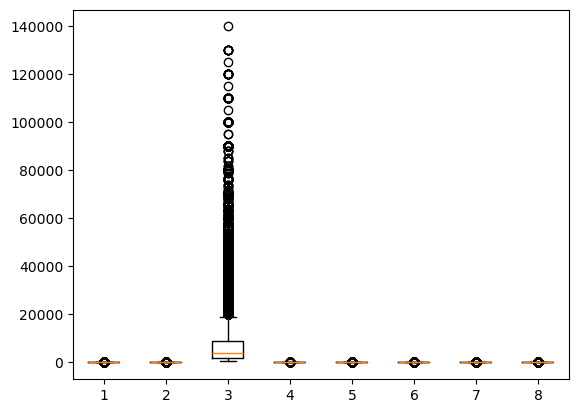

In [16]:
# All from lecture 6 and 7 Notes:

total_summary_df = casted_types_df_with_na_dropped_rows.drop("value_eur")

total_numeric_features = [feature[0] for feature in total_summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", total_numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
total_spotted_data = total_summary_df[total_numeric_features].toPandas()
total_figure_subset = plt.boxplot(total_spotted_data)


### Five-number Summary and Boxplots (Without wage_eur)

numeric features ['overall', 'potential', 'age', 'height_cm', 'skill_moves', 'physic', 'league_level']
dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):
################################
overall
min: 48
Q1: 61.0
median: 65.0
Q3: 70.0
max: 83
################################
potential
min: 54
Q1: 66.0
median: 70.0
Q3: 74.0
max: 86
################################
age
min: 16
Q1: 21.0
median: 24.0
Q3: 28.0
max: 38
################################
height_cm
min: 163
Q1: 176.0
median: 180.0
Q3: 185.0
max: 198
################################
skill_moves
min: 1
Q1: 2.0
median: 2.0
Q3: 3.0
max: 4
################################
physic
min: 37
Q1: 58.0
median: 66.0
Q3: 72.0
max: 92
################################
league_level
min: 1
Q1: 1.0
median: 1.0
Q3: 2.0
max: 3
################################


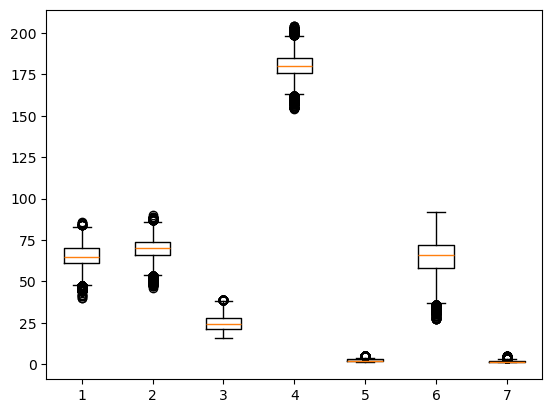

In [17]:
# top section from lecture 6 and 7 Notes:

summary_df = casted_types_df_with_na_dropped_rows.drop("wage_eur").drop("value_eur")

numeric_features = [feature[0] for feature in summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
spotted_data = summary_df[numeric_features].toPandas()
figure_subset = plt.boxplot(spotted_data)

# FIVE NUMBER SUMMARY:

print(figure_subset.keys())
medians = [item.get_ydata()[1] for item in figure_subset['medians']] # used part of a line from lecture 6 and 7 code
all_caps = [item.get_ydata()[1] for item in figure_subset['caps']]
boxes_low = [item.get_ydata()[1] for item in figure_subset['boxes']]
boxes_high = [item.get_ydata()[2] for item in figure_subset['boxes']]

# [item.get_ydata()[1] for item in figure_subset['whiskers']]

print("FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):")
print("################################")
for i in range(len(numeric_features)):
    counter = i*2
    print(f"{numeric_features[i]}")
    print(f"min: {all_caps[counter]}")
    print(f"Q1: {boxes_low[i]}")
    print(f"median: {medians[i]}")
    print(f"Q3: {boxes_high[i]}")
    print(f"max: {all_caps[counter+1]}")
    print("################################")

### Five-number Summary and Boxplots (wage_eur only)

#########################################################################
Wage should be plotted uniquely because its range makes all other variables extremely tiny by comparison
numeric features ['wage_eur']


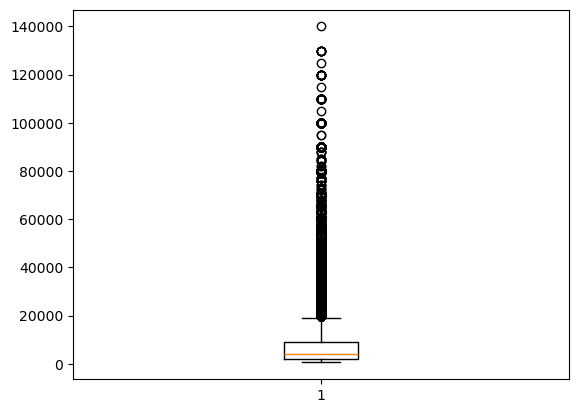

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):
################################
wage_eur
min: 500
Q1: 2000.0
median: 4000.0
Q3: 9000.0
max: 19000
################################
Wages clearly has a lot of outliers that we will handle in later steps. We are not removing this variable because of how much wage contributes to player value


In [18]:
print("#########################################################################")
print("Wage should be plotted uniquely because its range makes all other variables extremely tiny by comparison")
summary_df = casted_types_df_with_na_dropped_rows.select("wage_eur")

numeric_features = [feature[0] for feature in summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
spotted_data = summary_df[numeric_features].toPandas()
figure_subset = plt.boxplot(spotted_data)
plt.show()

# FIVE NUMBER SUMMARY:

print(figure_subset.keys())
medians = [item.get_ydata()[1] for item in figure_subset['medians']] # used part of a line from lecture 6 and 7 code
all_caps = [item.get_ydata()[1] for item in figure_subset['caps']]
boxes_low = [item.get_ydata()[1] for item in figure_subset['boxes']]
boxes_high = [item.get_ydata()[2] for item in figure_subset['boxes']]

# [item.get_ydata()[1] for item in figure_subset['whiskers']]

print("FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):")
print("################################")
for i in range(len(numeric_features)):
    counter = i*2
    print(f"{numeric_features[i]}")
    print(f"min: {all_caps[counter]}")
    print(f"Q1: {boxes_low[i]}")
    print(f"median: {medians[i]}")
    print(f"Q3: {boxes_high[i]}")
    print(f"max: {all_caps[counter+1]}")
    print("################################")

print("\033[1mWages clearly has a lot of outliers that we will handle in later steps. We are not removing this variable because of how much wage contributes to player value\033[0m")

### 4) Numeric Variables
#### a) Handling Outliers
- we use the total_figure_subset from the naive plot we showed initially

In [19]:
# printing outliers

[print(item.get_ydata()) for item in total_figure_subset['fliers']]

[46 47 47 46 47 45 47 47 47 47 47 47 47 47 41 47 47 47 47 47 47 47 47 47
 47 47 47 47 47 47 47 46 47 47 47 47 47 46 45 47 46 44 41 45 47 45 46 47
 47 45 47 47 46 47 47 47 45 46 46 40 47 47 47 45 45 47 47 47 44 47 46 47
 46 47 46 46 47 47 47 47 44 47 47 46 46 47 47 47 43 47 45 47 47 46 47 47
 47 47 47 45 47 46 46 46 47 47 47 46 45 44 47 47 46 47 47 44 46 47 47 47
 47 46 47 46 47 47 47 47 44 46 47 47 46 46 42 47 47 45 47 46 47 47 46 46
 46 47 47 45 47 44 47 47 47 47 45 44 46 46 46 47 47 47 46 46 47 42 47 47
 47 47 47 47 47 47 47 46 45 47 47 45 47 46 47 47 47 47 46 47 47 47 47 47
 47 47 47 44 47 47 46 47 47 47 45 46 47 47 47 47 47 47 47 44 46 44 47 44
 45 46 46 40 45 45 46 45 47 47 47 47 47 47 45 44 47 47 47 46 47 47 47 47
 45 47 47 84 85 84 84 84 85 85 84 84 84 84 86]
[53 53 53 53 52 49 52 53 51 48 52 52 53 53 51 52 50 52 53 53 51 52 52 53
 50 53 52 50 53 53 53 52 48 51 53 53 52 53 53 53 53 53 50 53 53 52 51 53
 49 53 53 53 53 53 52 53 53 52 52 51 52 53 51 52 50 52 52 52 52 53 52 53
 53 

[None, None, None, None, None, None, None, None]

In [20]:
# Making use of lecture code

from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [21]:
# From lecture 6 and 7 notes
total_summary_df = casted_types_df_with_na_dropped_rows

df_with_outlier_handling = find_outliers(total_summary_df)
df_with_outlier_handling.show(3, vertical=True)

-RECORD 0-----------------
 overall        | 78      
 potential      | 82      
 wage_eur       | 70000   
 age            | 22      
 height_cm      | 188     
 skill_moves    | 2       
 physic         | 75      
 value_eur      | 5500000 
 league_level   | 1       
 total_outliers | 2       
-RECORD 1-----------------
 overall        | 77      
 potential      | 79      
 wage_eur       | 80000   
 age            | 25      
 height_cm      | 186     
 skill_moves    | 2       
 physic         | 77      
 value_eur      | 5000000 
 league_level   | 1       
 total_outliers | 2       
-RECORD 2-----------------
 overall        | 75      
 potential      | 76      
 wage_eur       | 50000   
 age            | 27      
 height_cm      | 178     
 skill_moves    | 3       
 physic         | 57      
 value_eur      | 4000000 
 league_level   | 1       
 total_outliers | 2       
only showing top 3 rows



In [22]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1|17478|
|             3|  106|
|             4|    2|
|             2| 8480|
|             0|92461|
+--------------+-----+



#### We drop all rows with more than 1 outlier. We can expect eur_wage to frequently be an outlier, but we should drop other rows, which barely contribute to the data 

#### We are also dropping rows that contain value_eur as an outlier. While this may not seem ideal on the surface, it is a reasonable approach, since we want the input and the output data to be together BEFORE the data is scaled. 

In [23]:
# inspired from  LECTURE 6 and 7

df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_outliers']<=1)
print(df_with_substituted_na_and_outliers.count())

df_with_substituted_na_and_outliers.printSchema()

109939
root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- total_outliers: integer (nullable = false)



#### b) Identifying High Correlations

                 overall  potential       age  height_cm  skill_moves  \
overall         1.000000   0.543862  0.511988   0.060992     0.310602   
potential       0.543862   1.000000 -0.308016   0.006343     0.220279   
age             0.511988  -0.308016  1.000000   0.065249     0.093329   
height_cm       0.060992   0.006343  0.065249   1.000000    -0.275801   
skill_moves     0.310602   0.220279  0.093329  -0.275801     1.000000   
physic          0.499779   0.077433  0.441543   0.487083    -0.180969   
value_eur       0.693008   0.590924  0.108858   0.006156     0.304905   
league_level   -0.163681  -0.135270 -0.038055   0.079041    -0.058568   
total_outliers  0.292854   0.206040  0.101595   0.009019     0.121182   

                  physic  value_eur  league_level  total_outliers  
overall         0.499779   0.693008     -0.163681        0.292854  
potential       0.077433   0.590924     -0.135270        0.206040  
age             0.441543   0.108858     -0.038055        0.101595

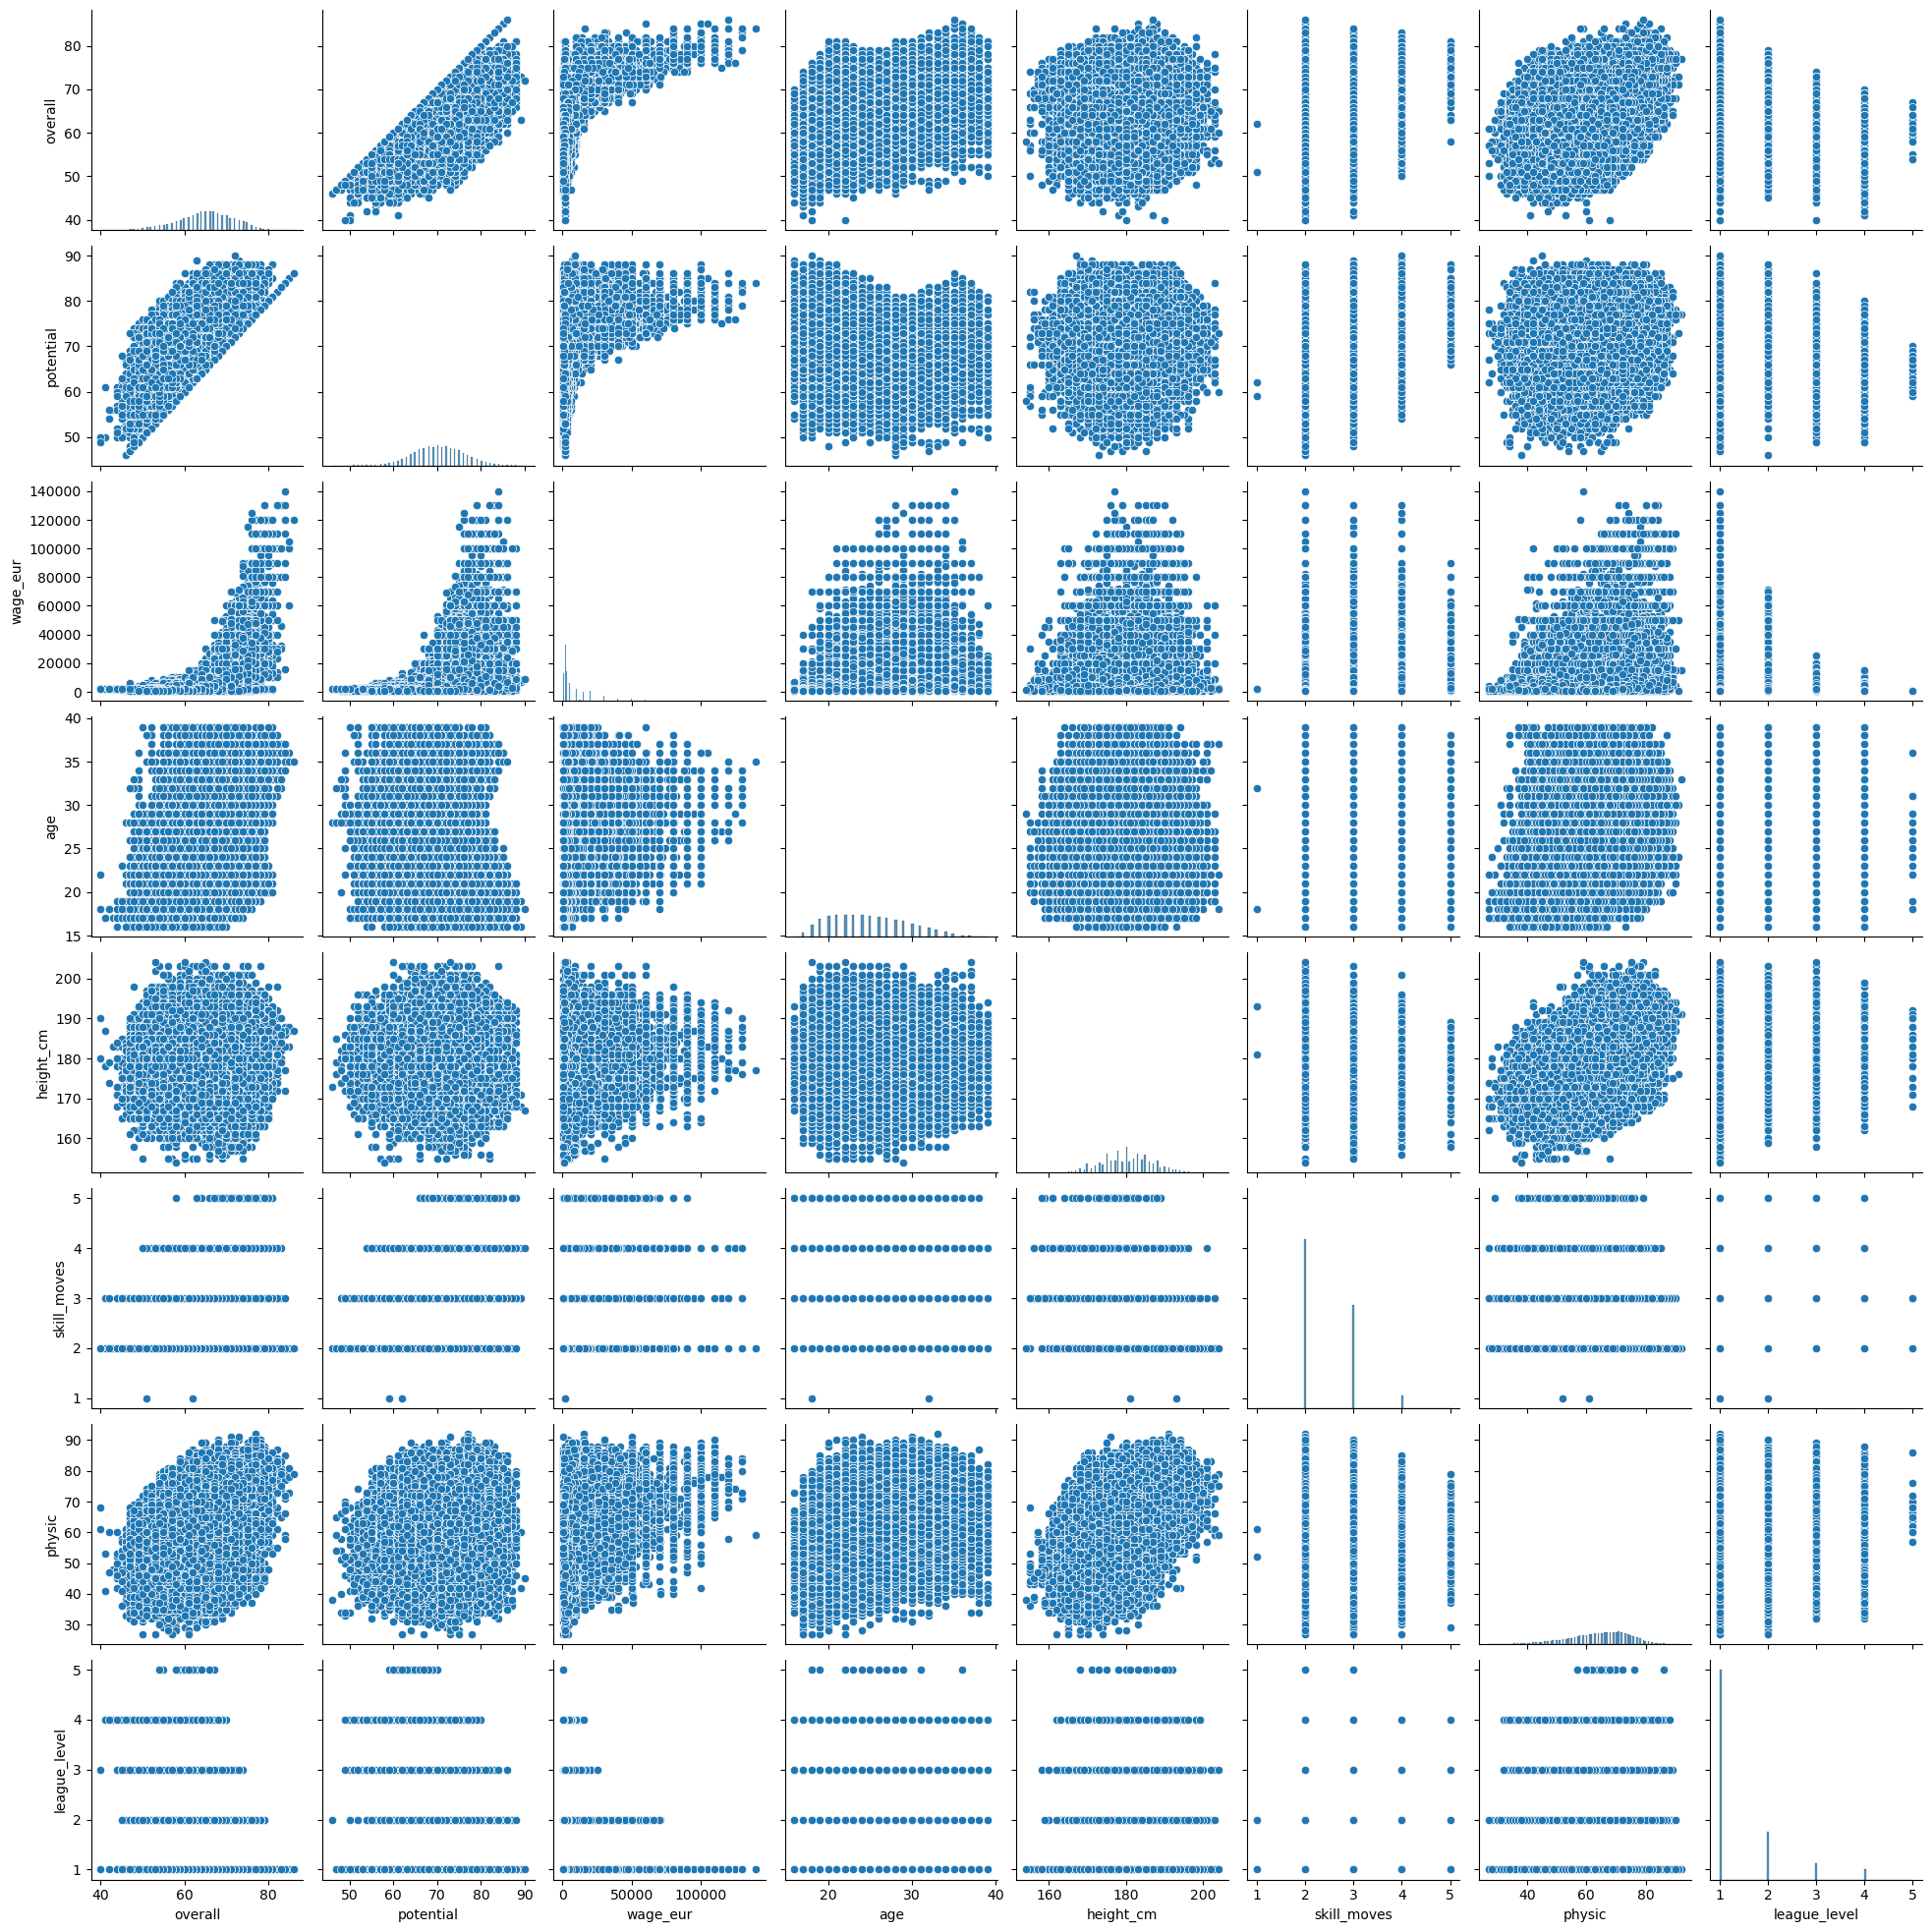

In [24]:
# Making use of lecture code

import seaborn as sb

sb.pairplot(total_spotted_data)

df_corr = df_with_substituted_na_and_outliers.drop("wage_eur")

correlation_matrix = df_corr.toPandas().corr()
print(correlation_matrix)

#### We drop potential because of its high correlation with overall. Furthermore, since we are calculating the current value of the player on the market, it makes less sense to use potential, since this is more indicative of the player's value in the future

In [25]:
dropped_corr_df = df_with_substituted_na_and_outliers.drop("potential")

#### Now, we have taken care of all continous and ordinal variables by dropping NaNs, nulls, outliers, and highly correlated features

### 6) Assembling Features Into One Vector

In [26]:
# ALL FROM LECTURE 6 and 7

feature_list = dropped_corr_df.columns
# print(feature_list)

feature_list.remove('value_eur')
print(feature_list)
dropped_corr_df.drop('value_eur')
    
from pyspark.ml.feature import VectorAssembler


vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(dropped_corr_df)

df_with_assembled_features.select("vectorized_features").distinct().toPandas()

['overall', 'wage_eur', 'age', 'height_cm', 'skill_moves', 'physic', 'league_level', 'total_outliers']


,vectorized_features
0,"[57.0, 3000.0, 24.0, 186.0, 2.0, 69.0, 2.0, 0.0]"
1,"[64.0, 2000.0, 22.0, 186.0, 2.0, 64.0, 1.0, 0.0]"
2,"[59.0, 500.0, 17.0, 187.0, 2.0, 58.0, 1.0, 0.0]"
3,"[56.0, 4000.0, 25.0, 178.0, 2.0, 61.0, 1.0, 0.0]"
4,"[63.0, 5000.0, 21.0, 170.0, 3.0, 60.0, 1.0, 0.0]"
...,...
107690,"[65.0, 9000.0, 26.0, 181.0, 2.0, 72.0, 1.0, 0.0]"
107691,"[69.0, 6000.0, 29.0, 179.0, 3.0, 61.0, 1.0, 0.0]"
107692,"[65.0, 2000.0, 28.0, 181.0, 2.0, 73.0, 2.0, 0.0]"
107693,"[64.0, 1000.0, 25.0, 191.0, 2.0, 70.0, 3.0, 0.0]"


### Data Scaling
#### We want to exclude value_eur from this

In [27]:
# ALL FROM LECTURE 6 and 7

from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select('features').distinct().toPandas()

,features
0,"[11.558558476485102, 1.2181595059649604, 6.564..."
1,"[11.213526880172115, 0.5414042248733157, 4.595..."
2,"[10.17843209123315, 0.5414042248733157, 3.9389..."
3,"[9.833400494920161, 0.09474573935283025, 6.346..."
4,"[12.076105870954585, 3.519127461676552, 7.2214..."
...,...
107690,"[11.386042678328609, 0.4060531686549868, 5.689..."
107691,"[10.17843209123315, 0.4060531686549868, 4.5954..."
107692,"[12.076105870954585, 2.7070211243665785, 5.033..."
107693,"[12.24862166911108, 1.3535105621832892, 5.0331..."


In [28]:
df_with_scaled_features.select('features').distinct().show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|[11.558558476485102,1.2181595059649604,6.564913408974171,29.354563783943792,5.3071583115465515,7.533184479368262,2.5641662056954933,0.0]             |
|[11.213526880172115,0.5414042248733157,4.59543938628192,27.48086822326653,3.538105541031034,6.068398608379989,1.2820831028477466,0.0]                |
|[10.17843209123315,0.5414042248733157,3.9389480453845027,27.324726926543423,5.3071583115465515,5.649888359526197,1.2820831028477466,0.0]             |
|[9.833400494920161,0.09474573935283025,6.346082962008365,28.886139893774477,3.538105541

In [29]:
df_with_scaled_features.show(5, truncate = False)

+-------+--------+---+---------+-----------+------+---------+------------+--------------+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|overall|wage_eur|age|height_cm|skill_moves|physic|value_eur|league_level|total_outliers|vectorized_features                       |features                                                                                                                                              |
+-------+--------+---+---------+-----------+------+---------+------------+--------------+------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|73     |40000   |26 |173      |3          |61    |2800000  |1           |1             |[73.0,40000.0,26.0,173.0,3.0,61.0,1.0,1.0]|[12.593653265424

### Features: SCALED

# Machine Learning Model

In [30]:
# normalize the label value
from pyspark.sql import functions as F
df_with_scaled_features = df_with_scaled_features.withColumn(
    "value_eur", F.col("value_eur") / 1000000
)

# Pyspark Model

In [31]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def spark_model_train(train_data, test_data, model_type, max_depth, num_trees=None, num_folds=3):
    if model_type == 'decision_tree':
        model = DecisionTreeRegressor(featuresCol="features", labelCol="value_eur", maxDepth=5)
        param_grid = ParamGridBuilder().addGrid(model.maxDepth, max_depth).build()
    elif model_type == 'random_forest':
        model = RandomForestRegressor(featuresCol="features", labelCol="value_eur", maxDepth=5, numTrees=10)
        param_grid = ParamGridBuilder().addGrid(model.numTrees, num_trees).addGrid(model.maxDepth, max_depth).build()
    else:
        assert "model type should be decision_tree or random_forest"

    evaluator = RegressionEvaluator(labelCol="value_eur", metricName="mae")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
    cv_model = crossval.fit(train_data)
    model_mae = evaluator.evaluate(cv_model.transform(test_data))
    print(f"{model_type} MAE: {model_mae}")

In [32]:
# Hyperparameter Tuning
train_data, test_data = df_with_scaled_features.randomSplit([0.8, 0.2], seed=42)

# Decision Tree
spark_model_train(train_data, test_data, 'decision_tree', [1, 5, 10]) # no num_trees param for desicion tree
spark_model_train(train_data, test_data, 'decision_tree', [10, 15, 20]) # no num_trees param for desicion tree

# Random Forest
spark_model_train(train_data, test_data, 'random_forest', [1, 5, 10], [5, 10, 20], 3) 


decision_tree MAE: 0.18696916808211564
decision_tree MAE: 0.18696916808211564
random_forest MAE: 0.20034918592550355


# Pytorch Model

In [33]:
import torch # now import the pytorch module
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.fc(x)

class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=128, hidden_size3=256):
        super(DeepNN, self).__init__()
        self.fc_deep = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, 1)
        )
    def forward(self, x):
        return self.fc_deep(x)

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(np.array(x.tolist()).astype(np.float32))
        self.y = torch.tensor(np.array(y).astype(np.float32))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

In [34]:
def pytorch_model_train(train_dataset, test_dataset, bs, lr, epochs, model_type, hidden_size1=64, hidden_size2=128, hiden_size3=256):
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    input_size = train_dataset[0][0].shape[0]
    if model_type == 'simpleNN':
        model = SimpleNN(input_size, hidden_size1)
    elif model_type == 'deepNN':
        model = DeepNN(input_size, hidden_size1, hidden_size2)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    batch_loss = 0
    # Train
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            X, y = batch
            optimizer.zero_grad()
            out = model(X)
            loss = loss_func(out.squeeze(), y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
        # print(f"Epoch{epoch} MSE Loss: {batch_loss/len(train_loader)}")
    # Test -  if the metric is MSE
    model.eval()
    with torch.no_grad():
        pred = []
        label = []
        for batch in test_loader:
            X, y = batch
            out = model(X)
            pred.extend(out.squeeze().numpy())
            label.extend(y.numpy())
    test_mse = np.mean((np.array(pred) - np.array(label)) ** 2)
    print(f"The test MSE is {test_mse}")

In [37]:
from sklearn.model_selection import train_test_split
data_pd = df_with_scaled_features.toPandas()
X_pd = data_pd['features']
y_pd = data_pd['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [38]:
# Hyperparameters Tuning

# simple NN
print("Param: bs=8, lr=1e-2, epochs=20, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 20, 'simpleNN', 64, 128, 256)
print("Param: bs=8, lr=1e-2, epochs=40, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 40, 'simpleNN', 64, 128, 256)
print("Param: bs=8, lr=1e-3, epochs=40, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-3, 40, 'simpleNN', 64, 128, 256)

print("---------------------------------------------------")
# Deep NN
print("Param: bs=8, lr=1e-2, epochs=20, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 20, 'deepNN', 64, 128, 256)
print("Param: bs=8, lr=1e-2, epochs=40, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 40, 'deepNN', 64, 128, 256)
print("Param: bs=8, lr=1e-3, epochs=40, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-3, 40, 'deepNN', 64, 128, 256)

Param: bs=8, lr=1e-2, epochs=20, type=simpleNN
The test MSE is 0.25131291151046753
Param: bs=8, lr=1e-2, epochs=40, type=simpleNN
The test MSE is 0.2972235679626465
Param: bs=8, lr=1e-3, epochs=40, type=simpleNN
The test MSE is 0.1781107485294342
---------------------------------------------------
Param: bs=8, lr=1e-2, epochs=20, type=deepNN
The test MSE is 0.15333525836467743
Param: bs=8, lr=1e-2, epochs=40, type=deepNN
The test MSE is 0.16111740469932556
Param: bs=8, lr=1e-3, epochs=40, type=deepNN
The test MSE is 0.10707855969667435
